<a href="https://colab.research.google.com/github/sv650s/sb-capstone2/blob/master/notebooks/6-atp_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATP Tennis Data - NN Using Diff Data

In [0]:
from google.colab import drive
drive.mount('/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD


import tensorflow as tf


%matplotlib inline
sns.set()

tf.test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

In [0]:
DRIVE_DIR = '/gdrive/My Drive/Springboard/capstone2'
DATASET_DIR = f'{DRIVE_DIR}/datasets'
MODEL_DIR = f'{DRIVE_DIR}/models'

FEATURE_FILE_1985 = f'{DATASET_DIR}/atp_matches_1985-2019_features.csv'
FEATURE_FILE_1998 = f'{DATASET_DIR}/atp_matches_1998-2019_features.csv'


FEATURE_FILE_1985_DIFF = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff.csv'
FEATURE_FILE_1998_DIFF = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff.csv'

FEATURE_FILE_1985_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-ohe.csv'
FEATURE_FILE_1998_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff-ohe.csv'

LABEL_COL = 'p1_winner'

sys.path.append(DRIVE_DIR)


In [0]:
features_orig = pd.read_csv(FEATURE_FILE_1998_DIFF)
print(features_orig.shape)
features_orig.head()

(57868, 18)


,age_diff,draw_size,ht_diff,p1,p1_hand,p1_ioc,p1_winner,p2,p2_hand,p2_ioc,rank_diff,round_label,seed_diff,surface_label,tourney_id_label,tourney_level_label,tourney_month,tourney_year
0,0.82,32.0,5.0,101917.0,1.0,64.0,0.0,102035.0,1.0,70.0,70.0,5.0,18.00,3.0,62.0,4.0,1.0,1998.0
1,-4.91,32.0,-10.0,102548.0,1.0,17.0,0.0,101727.0,1.0,3.0,8.0,5.0,1.00,3.0,62.0,4.0,1.0,1998.0
2,-1.32,32.0,0.0,102765.0,1.0,29.0,1.0,102491.0,1.0,32.0,22.0,5.0,3.92,3.0,62.0,4.0,1.0,1998.0
3,5.46,32.0,-5.0,101647.0,1.0,83.0,0.0,102563.0,1.0,70.0,37.0,5.0,14.00,3.0,62.0,4.0,1.0,1998.0
4,-3.77,32.0,0.0,102796.0,1.0,70.0,1.0,102104.0,1.0,54.0,-43.0,5.0,-21.37,3.0,62.0,4.0,1.0,1998.0


In [0]:
features = features_orig
# extra our label column
labels = features[LABEL_COL]
# one hot encode our labels for Keras
label_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
labels_encoded = label_encoder.fit_transform(features[[LABEL_COL]])
# drop this from our features
features = features.drop([LABEL_COL], axis=1)

features.head()

,age_diff,draw_size,ht_diff,p1,p1_hand,p1_ioc,p2,p2_hand,p2_ioc,rank_diff,round_label,seed_diff,surface_label,tourney_id_label,tourney_level_label,tourney_month,tourney_year
0,0.82,32.0,5.0,101917.0,1.0,64.0,102035.0,1.0,70.0,70.0,5.0,18.00,3.0,62.0,4.0,1.0,1998.0
1,-4.91,32.0,-10.0,102548.0,1.0,17.0,101727.0,1.0,3.0,8.0,5.0,1.00,3.0,62.0,4.0,1.0,1998.0
2,-1.32,32.0,0.0,102765.0,1.0,29.0,102491.0,1.0,32.0,22.0,5.0,3.92,3.0,62.0,4.0,1.0,1998.0
3,5.46,32.0,-5.0,101647.0,1.0,83.0,102563.0,1.0,70.0,37.0,5.0,14.00,3.0,62.0,4.0,1.0,1998.0
4,-3.77,32.0,0.0,102796.0,1.0,70.0,102104.0,1.0,54.0,-43.0,5.0,-21.37,3.0,62.0,4.0,1.0,1998.0


In [0]:
labels_encoded[:5]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [0]:
# split into training and test set
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(features, labels_encoded)
y_test = label_encoder.inverse_transform(y_test_encoded)

In [0]:
X_train.shape

(43401, 17)

# Implement Neural Network

LR is just a 1 layer dense network with softmax

We should get similar results as our [logistic regression notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/4-atp_logistic_regression.ipynb)

Baseline of our model is 65% accruacy



In [0]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, BatchNormalization
from keras import regularizers
import keras as K


output_dim = nb_classes = 2
model_lr = Sequential() 
model_lr.add(Dense(X_train.shape[1] * 3, 
                   input_shape=(X_train.shape[1], ),
                   kernel_regularizer=regularizers.l2(0.01),
                   kernel_initializer=K.initializers.glorot_uniform(seed=1))) 
model_lr.add(BatchNormalization())
model_lr.add(Activation("relu"))
# model_lr.add(Dropout(0.2))

model_lr.add(Dense(X_train.shape[1] * 3, 
                   kernel_regularizer=regularizers.l2(0.01),
                   kernel_initializer=K.initializers.glorot_uniform(seed=1))) 
model_lr.add(BatchNormalization())
model_lr.add(Activation("relu"))
# model_lr.add(Dropout(0.2))

model_lr.add(Dense(output_dim, 
                   kernel_initializer=K.initializers.glorot_uniform(seed=1))) 
model_lr.add(Activation("softmax"))
batch_size = 32 
epochs = 100

model_lr.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy']) 
model_lr.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 51)                918       
_________________________________________________________________
batch_normalization_19 (Batc (None, 51)                204       
_________________________________________________________________
activation_28 (Activation)   (None, 51)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 51)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 51)                2652      
_________________________________________________________________
batch_normalization_20 (Batc (None, 51)                204       
_________________________________________________________________
activation_29 (Activation)   (None, 51)              

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
             ModelCheckpoint(filepath=f'{MODEL_DIR}/lr.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.4,patience=2, min_lr=0.00001, mode='auto')]


history = model_lr.fit(X_train, y_train_encoded, 
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1, 
                       validation_split=0.2,
                       callbacks=callbacks) 

# evalute our model
score = model_lr.evaluate(X_test, y_test_encoded, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 34720 samples, validate on 8681 samples
Epoch 1/100
34720/34720 [==============================] - 9s 259us/step - loss: 0.7263 - acc: 0.5338 - val_loss: 0.7204 - val_acc: 0.5423
Epoch 2/100
34720/34720 [==============================] - 8s 221us/step - loss: 0.6786 - acc: 0.5834 - val_loss: 5.6209 - val_acc: 0.4982
Epoch 3/100
34720/34720 [==============================] - 8s 222us/step - loss: 0.6692 - acc: 0.6005 - val_loss: 3.1483 - val_acc: 0.4982
Epoch 4/100
34720/34720 [==============================] - 8s 221us/step - loss: 0.6604 - acc: 0.6135 - val_loss: 4.4124 - val_acc: 0.4982
Epoch 5/100
34720/34720 [==============================] - 8s 220us/step - loss: 0.6595 - acc: 0.6154 - val_loss: 0.6703 - val_acc: 0.5901
Epoch 6/100
34720/34720 [==============================] - 8s 221us/step - loss: 0.6582 - acc: 0.6181 - val_loss: 0.7095 - val_acc: 0.5170
Epoch 7/100
34720/34720 [==============================] - 8s 220us/step - loss: 0.6555 - acc: 0.6233 - val_loss: 1.5

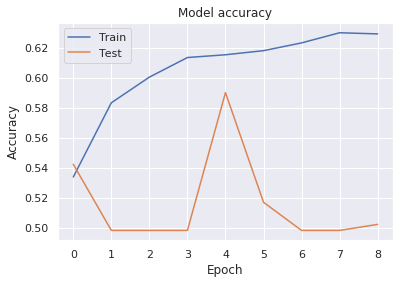

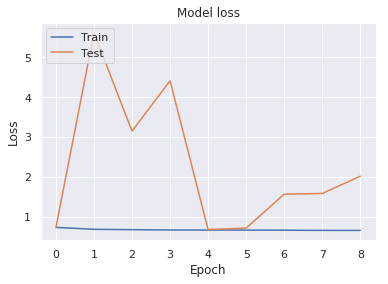

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# use our model to predict
y_predict_encoded = model_lr.predict(X_test)


In [0]:
y_predict_encoded[:20]

array([[0.45116225, 0.5488378 ],
       [0.47045255, 0.52954745],
       [0.38274476, 0.6172552 ],
       [0.40085313, 0.59914684],
       [0.4164451 , 0.58355486],
       [0.42741182, 0.57258815],
       [0.45037073, 0.5496293 ],
       [0.4057005 , 0.59429944],
       [0.44861192, 0.5513881 ],
       [0.4403318 , 0.5596682 ],
       [0.38025296, 0.619747  ],
       [0.5110385 , 0.48896155],
       [0.4494965 , 0.5505035 ],
       [0.46884942, 0.5311506 ],
       [0.30482522, 0.69517475],
       [0.42869243, 0.5713076 ],
       [0.4579004 , 0.54209965],
       [0.42415947, 0.57584053],
       [0.502757  , 0.497243  ],
       [0.4072299 , 0.59277016]], dtype=float32)

In [0]:
y_predict = [row.idxmax() for index, row in pd.DataFrame(y_predict_encoded).iterrows()]
y_predict[:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]

In [0]:
print(classification_report(y_test, y_predict, target_names=["loss", "win"]))

              precision    recall  f1-score   support

        loss       0.72      0.31      0.43      7283
         win       0.55      0.88      0.68      7184

    accuracy                           0.59     14467
   macro avg       0.64      0.59      0.55     14467
weighted avg       0.64      0.59      0.55     14467



[[2222 5061]
 [ 878 6306]]


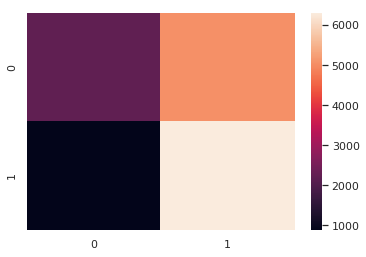

In [0]:
cm = confusion_matrix(y_test, y_predict)
print(cm)
sns.heatmap(cm)